In [1]:
#import av
import numpy as np
import math
#import trackpy
#import matplotlib #for making plots inside the notebook 
import matplotlib.pyplot as plt #for maknig plots inside the notebook
import skimage
import skvideo.io
from operator import attrgetter
import seaborn as sns
from operator import attrgetter
from itertools import chain
from skimage import measure
from skimage import morphology
from skimage.util import invert
from skimage.filters import threshold_isodata, threshold_yen, try_all_threshold
from scipy import ndimage
from glob import glob
from skvideo.io import vread
"""Currently works on a single frame. Later, will add a loop that can work on all frames."""

'Currently works on a single frame. Later, will add a loop that can work on all frames.'

In [18]:
# take largest isodata image region, and return aclassification
def sideify(idir):
    iner = idir.inertia_tensor[0, 0] + idir.inertia_tensor[1, 1]
    maal = idir.major_axis_length
    mial = idir.minor_axis_length
    sol = idir.solidity 
    ecc = idir.eccentricity
    cva = idir.convex_area
    area = idir.area
    if area < 1470:
        return "ucf"
    elif ecc <= 0.79 and  maal > 65.5:
        return "b_m"
    elif ecc > 0.81 and cva < 2140: # maal > 67.5 and or (mial < 41 and maal > 65): # it's on top
        return "t"
    elif  maal < 63: #or mial > 42  #and cva > 2200 and iner < 325: #or (maal < 64 and iner < 360): # it's on bottom
        return "b"
    else:
        return "ucf"

def classify(side, coprod):
    if side == "t":
        if coprod > 0:
            return "t_l"
        else:
            return "t_r"
    elif side == "b": 
        if coprod > 0:
            return "b_r"
        else:
            return "b_l"
    elif side == "b_m":
        return "b_m"
    elif side == "ucf":
        return "ucf"
    else:
        return "newt"


def coord_prod(thresh_y, thresh_i):
    m_rop = measure.regionprops
    for i in range(0, 1):#len(fl):
        full = largest_region_extractor(measure.label(thresh_y))
        four = largest_region_extractor(measure.label(thresh_i))
        full_or = m_rop(full.astype(int), coordinates = 'rc')[0].orientation
        one_and_some = full^four
        one = largest_region_extractor(measure.label(one_and_some))
        
          
        #Begin finding substitue for major and minor axes herre
        # use min and maax x and  values to find the geometric center
        # or use those to substitue for eigenvectors 
        rotated_one = ndimage.rotate(one, math.degrees(-full_or), reshape = False)
        rotated_full = ndimage.rotate(full, math.degrees(-full_or), reshape = False)
        geo_cent = m_rop(rotated_full.astype(int), coordinates = 'rc')[0].bbox
        #print(geo_cent)
        ave = np.average
        cent_x = ave([geo_cent[1], geo_cent[3]]) 
        cent_y = ave([geo_cent[0], geo_cent[2]])
        #print(cent_x, cent_y)
        
        raw_coords = (m_rop(rotated_full.astype(int), coordinates = 'rc')[0].coords).T
        ys = raw_coords[0]
        xs = raw_coords[1]
        x = xs - cent_x
        y = ys - cent_y      
        
        one_com = m_rop(rotated_one.astype(int))[0].centroid
        
        rel_com_one = (one_com[1] - cent_x, one_com[0] - cent_y)
        product = np.prod(rel_com_one)
        return product
        
def rotate_point(point, angle):
    x0 = point[0]
    y0 = point[1]
    x1 = x0*np.cos(angle) - y0*np.sin(angle)
    y1 = x0*np.sin(angle) + y0*np.cos(angle)
    return (x1, y1)
 
def region_selector(labeled_image, label):
    #print(label)
    x = labeled_image == label
    #plt.imshow(x)
    return x

# make a function that takes a set of labeled regions, and then  returns a boolean array containing only the largest
def largest_region_extractor(labeled_regions_set):
    props_lists = measure.regionprops(labeled_regions_set)
    #print(len(labeled_regions_set), len(props_lists))
    biggest_r_p = props_lists[0]
    biggest_r_label = props_lists[0].label
    for i in range(0, len(props_lists)):
        pli = props_lists[i]
        if pli.area > biggest_r_p.area:
            biggest_r_p = pli
            biggest_r_label = pli.label
        else:
            pass
    return region_selector(labeled_regions_set, biggest_r_label)    
#from pair of labelled, thresholded images, return an image category (of three)

#from pair of labelled,thresholded images, return the x/y sign or x/y magnitude for the transparent dot


In [7]:
"Filtering broken ad oddframes"
# apply total thresholding to each of a list of frames; filter slides with wrong number
def total_threshold_filter(framelist, framesetname): 
    # returns a new list, different from the orginal
    fll = len(framelist)
    m_lab = measure.label
    m_rop = measure.regionprops
    area_threshold = 1800   # must have enough particles
    convex_thresholds = (2000, 2800)   # convex hull area (> 2500 filtered)  # particles must be in parallelogram
    minor_thresholds = (38, 48) # minor_axis length (< filterd) # particles must be in parallelogram
    major_thresholds = (59, 76)
    filtrate_prop =[]
    trash = []
    total = []
    
    for i in range(fll):
       # print("new_frame")
        frame = framelist[i]
        thresh_img = frame > threshold_yen(frame) # binary image
        img_labelled = m_lab(thresh_img) # contains connected regions
        properties_list = m_rop(img_labelled, coordinates = 'rc') # data about regions, for each connected region
        
        #----------getting maximum connected region----------
        biggest_r = max(properties_list, key = attrgetter('area'))
        total.append(biggest_r)
        """ for k in range(len(properties_list)):
            if areas[k] > biggest_area:
                biggest_r = properties_list[k]
            else:
                pass"""

        #----------------------filter------------------------- can use actual filter
        test = (biggest_r.filled_area > area_threshold and
                #biggest_r.eccentricity < ecc_threshold and# must have enough particles
            biggest_r.minor_axis_length > minor_thresholds[0] # minor_axis length (< filterd) # particles must be in parallelogram
            and biggest_r.minor_axis_length < minor_thresholds[1]  # minor_axis length (< filterd) # particles must be in parallelogram
            and biggest_r.convex_area > convex_thresholds[0]  # convex hull area (> 2500 filtered)  # particles must be in parallelogram
            and biggest_r.convex_area < convex_thresholds[1]  # convex hull area (> 2500 filtered)  # particles must be in parallelogram
            and biggest_r.major_axis_length > major_thresholds[0]  # major_axis length (< filterd) # particles must be in parallelogram
            and biggest_r.major_axis_length < major_thresholds[1])   # major_axis length (< filterd) # particles must be in parallelogram
        if test: # keep frames that have enough paricles, and are not transitions
            i_threshed = frame > threshold_isodata(frame)
            img2_labelled = m_lab(i_threshed)
            properties2_list = m_rop(img2_labelled, coordinates = 'rc')
            biggest_r2 = max(properties2_list, key = attrgetter('area'))
            #-----------------------------classify pt 1---------------------------------------
            coprod = coord_prod(thresh_img, i_threshed)
            side = sideify(biggest_r2)
            clas = classify(side, -coprod)
            if clas == framesetname:
                filtrate_prop.append((biggest_r, biggest_r2))
        else:
            trash.append(biggest_r)
        total.append(biggest_r)
    return [filtrate_prop, trash, total]






In [8]:
"Retreving properties for test frames with 1st hreshold"
# applies yen filter to test frames, and gets properties
# returns list of the properties
#  fraemelist is a frame and a frame index
def opaque_threshold_properties(framelist, indes):
    filtrate = []
    for i in range(len(framelist)):
        frame = framelist[i]
        thresh_img = frame > threshold_yen(frame) # binary image
        img_labelled = measure.label(thresh_img) # contains connected regions
        properties_list = measure.regionprops(img_labelled, coordinates = 'rc') # data about regions, for each connected region
        
        #----------getting maximum connected region----------
        biggest_r = properties_list[0] 
        
        for region in properties_list:
            if region.area > biggest_r.area:
                biggest_r = region
            else:
                pass
            
        filtrate.append(biggest_r)#, total_threshed]) # area, frame index in phantom, binary image
    return filtrate

In [9]:
"Retreving properties for test frames with 2nd threshold"

# applies isodata filter to test frames, and gets properties
# returns list of the properties
def transparent_threshold_properties(framelist, indes):
    filtrate = []
    for i in range(len(framelist)):
        frame = framelist[i]
        thresh_img = frame > threshold_isodata(frame) # binary image
        img_labelled = measure.label(thresh_img) # contains connected regions
        properties_list = measure.regionprops(img_labelled, coordinates = 'rc') # data about regions, for each connected region
        
        #----------getting maximum connected region----------
        biggest_r_p = properties_list[0] 
        
        for region_props in properties_list:
            region = img_labelled
            if region_props.area > biggest_r_p.area:
                biggest_r_p = region_props
            else:
                pass
            
        filtrate.append(biggest_r_p)#, total_threshed]) # area, frame index in phantom, binary image
    return filtrate


In [10]:
filenames = ["./tchakamau/New_setup/45681_10Vpp_25.avi", "./tchakamau/New_setup/45701_10Vpp_20_tester.avi",
             "./tchakamau/New_setup/45701_10Vpp_18_tester.avi", "./tchakamau/New_setup/45701_10Vpp_18_tr.avi" ] #glob("./tchakamau/New_setup/*.avi")# glob("./tchakamau/New_setup/45681_10Vpp_25.avi") #filenames = 
print(filenames)
num_shape_cats = 7
"""Pass_ratios = np.zeros((len(filenames), num_shape_cats))
    I_thresh_props = []
    T_thresh_props = []
    Filtrates_props= []"""



"""TEST FRAME RANGES FROM VIDEOs"""
phantom_frames_2 = {"b_r" : list(range(49200, 48816, -1)),
                  "t_r" : list(range(63474, 63083, -2)), "t_l" : list(range(47300, 46929, -1)),
                  "b_m" : list(range(27494, 27094, -2)), "b_l" : list(range(41509, 41215, -1)),
                 "broken" : list(chain(range(57126, 57044, -1), range(56772, 56691, -1),
                                      range(35975, 35940, -1))),
                 "odd_s" : list(chain(range(57419, 57293, -1), range(55453, 55416, -1), range(55519, 55497, -1),
                                    range(56820, 56773, -1), range(35938, 35845, -1), range(56077, 56002, -1) ))}
phantom_frames = {"b_r" : list(range(10950, 10772, -1)),
                  "t_r" : list(range(17866, 17580, -1)), "t_l" : list(chain(range(16849, 16778, -1),
                                                                           range(17060, 16956, -1))),
                  "b_m" : list(range(20947, 19727, -4)), "b_l" : list(chain(range(25979, 25819, -1),
                                                                      range(26073, 26005, -1))),
                 "broken" : list(chain(range(11525, 11202, -3), range(24966, 24590, -3), range(21624, 21066, -3))),
                 "odd_s" : list(chain(range(21066, 21036, -1), range(18071, 18052, -1), range(17948, 17910, -1),
                                    range(15671, 15659, -1) ))}
phantom_frames_3 = {"b_r" : list(range(1216, 2026, 3)),
                  "t_r" :[], "t_l" : list(range(7292, 11991, 20)),
                  "b_m" : list(chain(range(1, 238, 2), range(16058, 17239, 10))), 
                    "b_l" : list(range(2755, 3647, 3)),
                 "broken" :list(range(12315, 12600)) ,
                 "odd_s" :list(chain(range(13450, 13475), range(1036, 1053), range(4009, 4038))) }
phantom_frames_4 = {"b_r" : [],
                  "t_r" :list(range(28861, 28363, -2)), "t_l" : [],
                  "b_m" : [], "b_l" :[] ,
                 "broken" :[] ,
                 "odd_s" :[] }
phantom_frame_sets = [phantom_frames, phantom_frames_2, phantom_frames_3, phantom_frames_4]
trigger_frames = [26894, 63474, 1, 28861]

['./tchakamau/New_setup/45681_10Vpp_25.avi', './tchakamau/New_setup/45701_10Vpp_20_tester.avi', './tchakamau/New_setup/45701_10Vpp_18_tester.avi', './tchakamau/New_setup/45701_10Vpp_18_tr.avi']


In [19]:
b_r_frames = []
brvals  = []
b_l_frames = []
blvals = []
t_r_frames = []
trvals = []
t_l_frames = []
tlvals = []
b_m_frames = []
bmvals = []
odd_s_frames = []
oddsvals = []
broken_frames = []
brokenvals = []
odd_only_frames = []
oddovals = []
few_frames = []
fewvals = []

framesets = [b_r_frames, b_l_frames, t_r_frames, t_l_frames, b_m_frames, odd_s_frames, 
             broken_frames]
frametypevals = [brvals, blvals, trvals, tlvals, bmvals, oddsvals, brokenvals]
framesetnames = ["b_r", "b_l", "t_r", "t_l", "b_m", "odd_s", "broken"]
filtrates_props = []
passes = []
i_props = []
t_props = []
    
for vidnum in range(len(filenames)):
    frames = vread(filenames[vidnum])
    frame_vid = frames[:, :, :, 2]# making videos ino a frame list
    print(len(frame_vid))
    
    
    for i in range(len(framesetnames)):
        typevals = phantom_frame_sets[vidnum].get(framesetnames[i])
        frametypevals[i].extend(typevals)
        framesets[i].extend([frame_vid[trigger_frames[vidnum] - x], x] for x in typevals)
        


16123
36381
18229
499


In [ ]:
for i in range(len(framesetnames)):
    x = total_threshold_filter([y[0] for y in framesets[i]], framesetnames[i])
    filtrates_props.append(x[0])
    #all_props.append(x[2])
    #print(framesets[i])

    orig = len(frametypevals[i])
    fil = len(filtrates_props[i])
    print(orig, fil, len(x[0]))
    print(framesetnames[i], "_vid")
    print("original_vid: ", orig)
    print("filtrate: ", fil)
    print("pass ratio: ", fil*100/orig)
    print("\n")
    passes.append(fil*100/orig)

    i_props.append(opaque_threshold_properties([x[0] for x in framesets[i]], frametypevals[i]))
    t_props.append(transparent_threshold_properties([x[0] for x in framesets[i]], frametypevals[i]))

Pass_ratios = passes
Filtrates_props = filtrates_props
I_thresh_props = i_props
T_thresh_props = t_props

832 549 549
b_r _vid
original_vid:  832
filtrate:  549
pass ratio:  65.98557692307692


820 444 444
b_l _vid
original_vid:  820
filtrate:  444
pass ratio:  54.146341463414636


731 502 502
t_r _vid
original_vid:  731
filtrate:  502
pass ratio:  68.67305061559507


781 564 564
t_l _vid
original_vid:  781
filtrate:  564
pass ratio:  72.21510883482715


743 490 490
b_m _vid
original_vid:  743
filtrate:  490
pass ratio:  65.94885598923284


570 0 0
odd_s _vid
original_vid:  570
filtrate:  0
pass ratio:  0.0




Area averages: 
b_r : ave - 2037 var - 142 % 
b_l : ave - 2021 var - 357 % 
t_r : ave - 1985 var - 276 % 
t_l : ave - 1967 var - 280 % 
b_m : ave - 1950 var - 1373 % 
odd_s : ave - 1971 var - 471 % 
broken : ave - 1390 var - 15331 % 


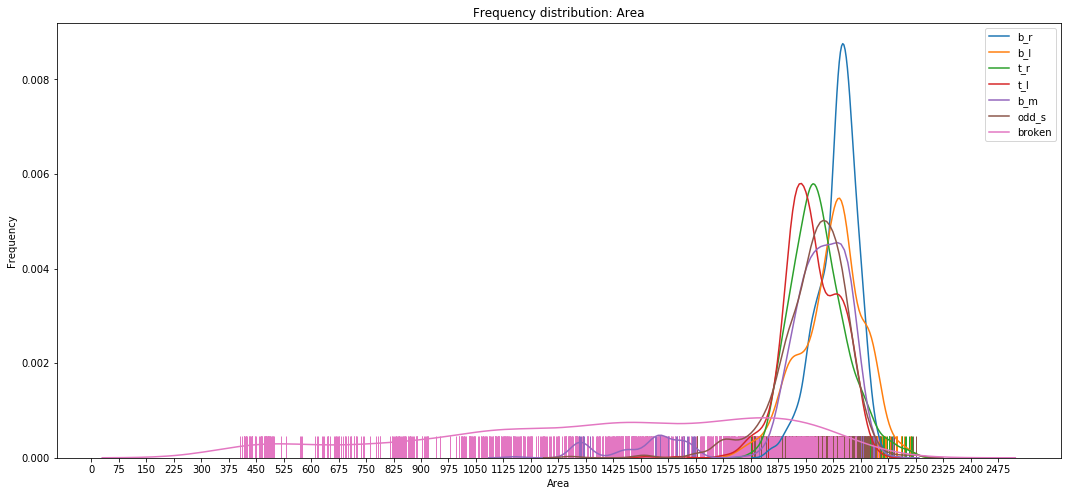

In [25]:
"""Determining the correct area threshold"""
# use area information from properties
Areas_list = []
for i in range(num_shape_cats):
    x = [h.area for h in I_thresh_props[i]]
    Areas_list.append(x) #list of areas for every category
print("Area averages: ")
[print("%s : ave - %.f var - %.f %% " %(framesetnames[i], np.average(Areas_list[i]),
                                       np.var(Areas_list[i]) *100/ np.average(Areas_list[i])
                                       )) for i in range(num_shape_cats)]

fig, ax = plt.subplots(figsize=(18,8))
plt.xticks(np.arange(0, 2501, 75))
plt.title("Frequency distribution: Area")
plt.xlabel("Area")
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = Areas_list[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])

Inertia averages: 
b_r : 406 
b_l : 397 
t_r : 419 
t_l : 413 
b_m : 400 
odd_s : 408 
broken : 284 
Inertia variances: 
b_r : 337 
b_l : 360 
t_r : 271 
t_l : 330 
b_m : 1926 
odd_s : 2360 
broken : 10411 
convex_area averages: 
b_r : 2442 
b_l : 2399 
t_r : 2418 
t_l : 2374 
b_m : 2377 
odd_s : 2379 
broken : 1662 
convex_area variances: 
b_r : 5141 
b_l : 7061 
t_r : 12402 
t_l : 6522 
b_m : 46531 
odd_s : 33579 
broken : 323003 
minor_axis_length averages: 
b_r : 45 
b_l : 44 
t_r : 43 
t_l : 42 
b_m : 45 
odd_s : 44 
broken : 37 
minor_axis_length variances: 
b_r : 1 
b_l : 2 
t_r : 2 
t_l : 1 
b_m : 3 
odd_s : 22 
broken : 51 
major_axis_length averages: 
b_r : 67 
b_l : 67 
t_r : 70 
t_l : 70 
b_m : 66 
odd_s : 67 
broken : 55 
major_axis_length variances: 
b_r : 3 
b_l : 7 
t_r : 4 
t_l : 6 
b_m : 26 
odd_s : 43 
broken : 163 
solidity averages: 
b_r : 1 
b_l : 1 
t_r : 1 
t_l : 1 
b_m : 1 
odd_s : 1 
broken : 1 
solidity variances: 
b_r : 0 
b_l : 0 
t_r : 0 
t_l : 0 
b_m : 0 

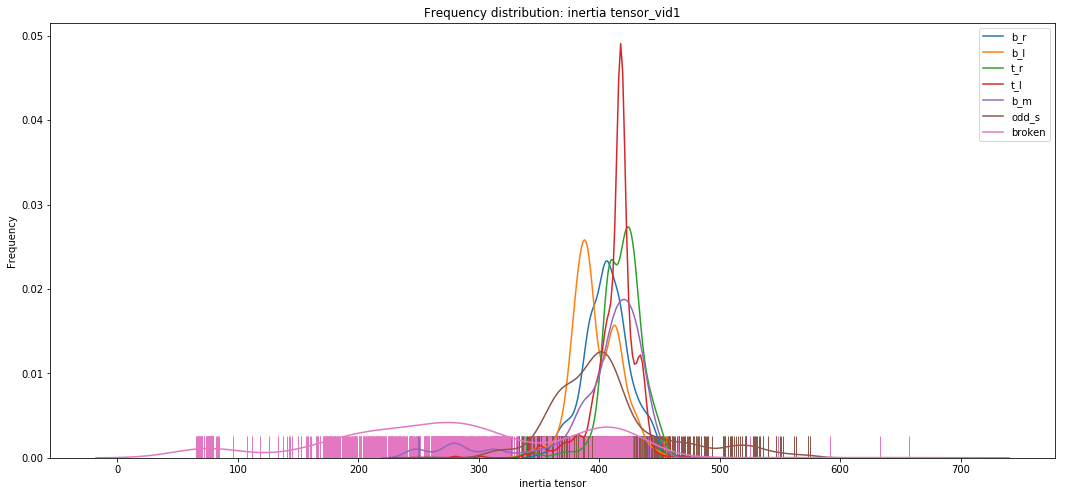

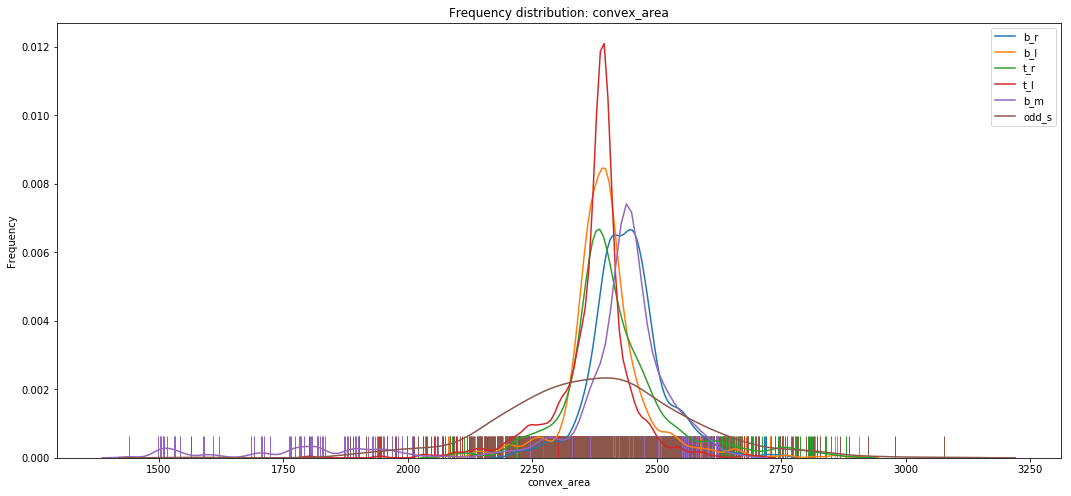

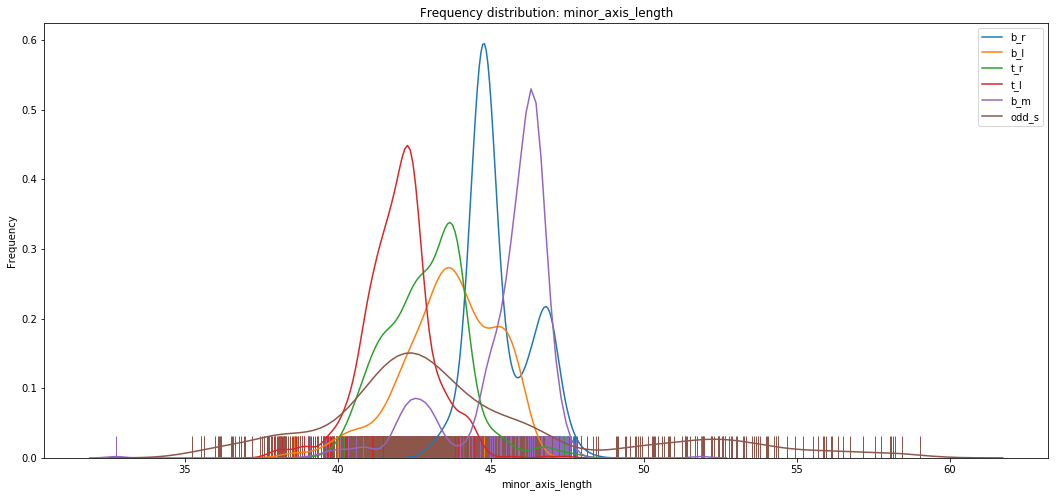

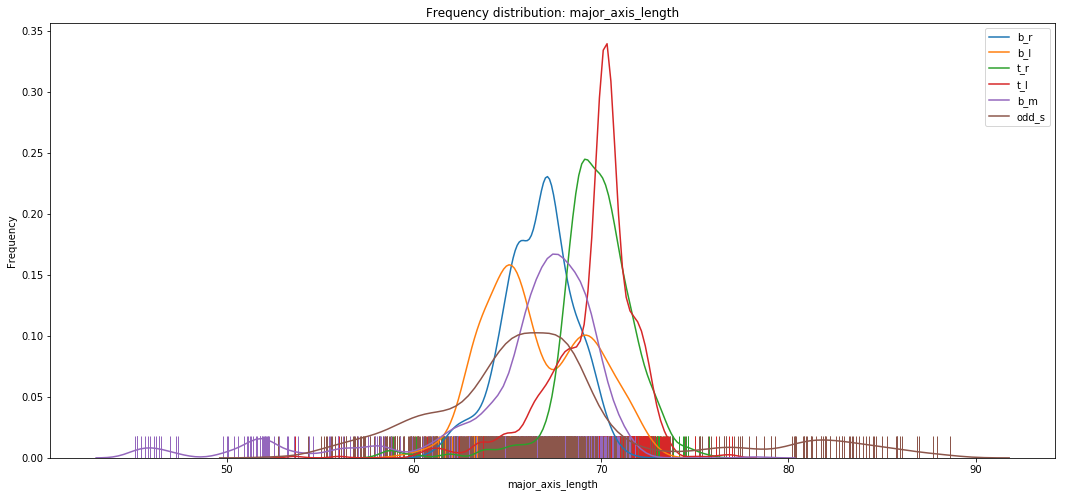

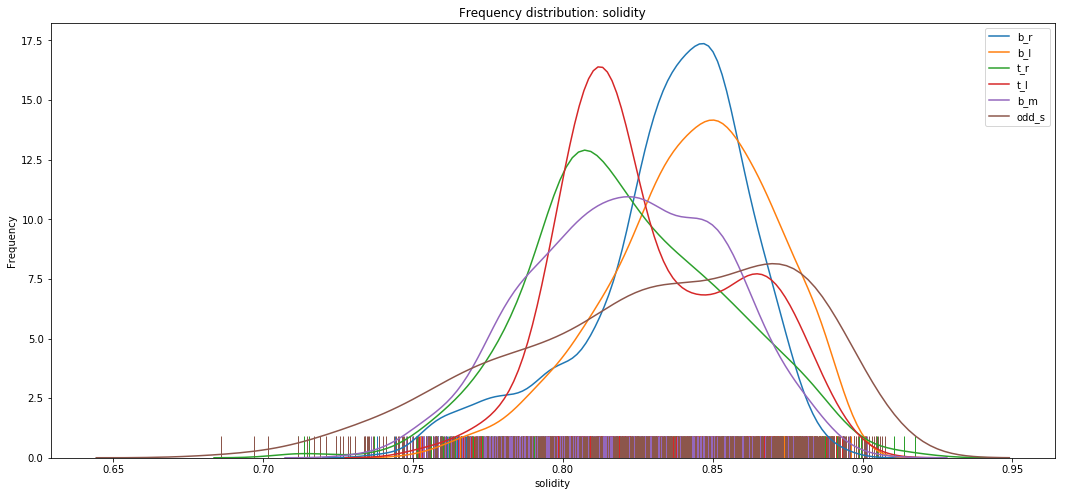

In [10]:
"""FINDING CORRECT THRESHOLDS FOR SEPARATING ODD SHAPED FRAMES"""

# use area information from properties
Inertias_list = []
for i in range(num_shape_cats):
    x = [h.inertia_tensor[0, 0] + h.inertia_tensor[1,1] for h in I_thresh_props[i]]
    Inertias_list.append(x) #list of areas for every category
print("Inertia averages: ")
[print("%s : %.f " %(framesetnames[i], np.average(Inertias_list[i]))) for i in range(num_shape_cats)]
print("Inertia variances: ")
[print("%s : %.f " %(framesetnames[i], np.var(Inertias_list[i]))) for i in range(num_shape_cats)]

fig, ax = plt.subplots(figsize=(18,8))
plt.title("Frequency distribution: inertia tensor_vid1")
plt.xlabel("inertia tensor")
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = Inertias_list[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])

propnames = ["convex_area", "minor_axis_length", "major_axis_length", "solidity"]
for k in range(0, len(propnames)):
    klist = []
    for i in range(num_shape_cats):
        x = [getattr(h, propnames[k]) for h in I_thresh_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + propnames[k])
    plt.xlabel(propnames[k])
    plt.ylabel("Frequency")
    for j in range(0, len(framesets)-1):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])



"""Broken objects are filtered out by their area and we then move on to identifying odd shaped objects 
    from the remaining frames"""
framesets.remove(broken_frames)
framesetnames.remove("broken")

b_r : ave - 2046 var - 99% 
b_l : ave - 2022 var - 218% 
t_r : ave - 1979 var - 221% 
t_l : ave - 1972 var - 225% 
b_m : ave - 2000 var - 186% 
odd_s : ave - nan var - nan% 
broken : ave - nan var - nan% 


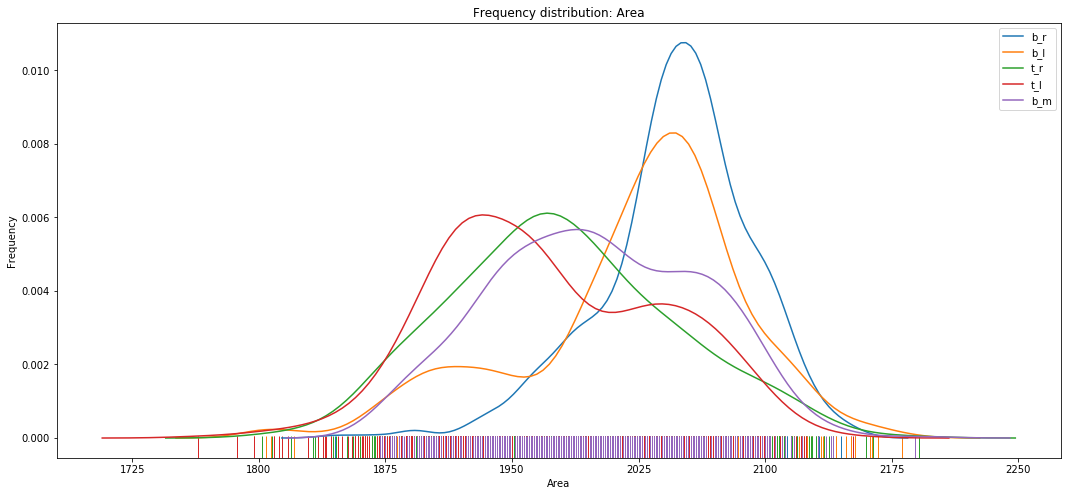

In [24]:
"""PTINTING RESULTS OF FILTERING"""
# use area information from properties
Areas_list = []
for i in range(num_shape_cats):
    x = [h[0].area for h in Filtrates_props[i]]
    Areas_list.append(x) #list of areas for every category
#print("Area averages: ")
[print("%s : ave - %.f var - %.f %% " %(framesetnames[i], np.average(Areas_list[i]),
                                   np.var(Areas_list[i])*100/ np.average(Areas_list[i])
                                  )) for i in range(num_shape_cats)]
fig, ax = plt.subplots(figsize=(18,8))
plt.xticks(np.arange(0, 2501, 75))
plt.title("Frequency distribution: Area")
plt.xlabel("Area")
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = Areas_list[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
   


Inertia averages: 
b_r : 398 
b_l : 388 
t_r : 420 
t_l : 415 
b_m : 422 
odd_s : nan 
broken : nan 
Inertia variances: 
b_r : 199 
b_l : 128 
t_r : 157 
t_l : 184 
b_m : 132 
odd_s : nan 
broken : nan 
convex_area averages: 
b_r : 2417 
b_l : 2397 
t_r : 2410 
t_l : 2383 
b_m : 2467 
odd_s : nan 
broken : nan 
convex_area variances: 
b_r : 3664 
b_l : 3943 
t_r : 6492 
t_l : 3808 
b_m : 2796 
odd_s : nan 
broken : nan 
minor_axis_length averages: 
b_r : 45 
b_l : 44 
t_r : 43 
t_l : 42 
b_m : 46 
odd_s : nan 
broken : nan 
minor_axis_length variances: 
b_r : 0 
b_l : 1 
t_r : 1 
t_l : 1 
b_m : 0 
odd_s : nan 
broken : nan 
major_axis_length averages: 
b_r : 66 
b_l : 65 
t_r : 70 
t_l : 70 
b_m : 68 
odd_s : nan 
broken : nan 
major_axis_length variances: 
b_r : 3 
b_l : 2 
t_r : 2 
t_l : 3 
b_m : 2 
odd_s : nan 
broken : nan 
solidity averages: 
b_r : 1 
b_l : 1 
t_r : 1 
t_l : 1 
b_m : 1 
odd_s : nan 
broken : nan 
solidity variances: 
b_r : 0 
b_l : 0 
t_r : 0 
t_l : 0 
b_m : 0 
od

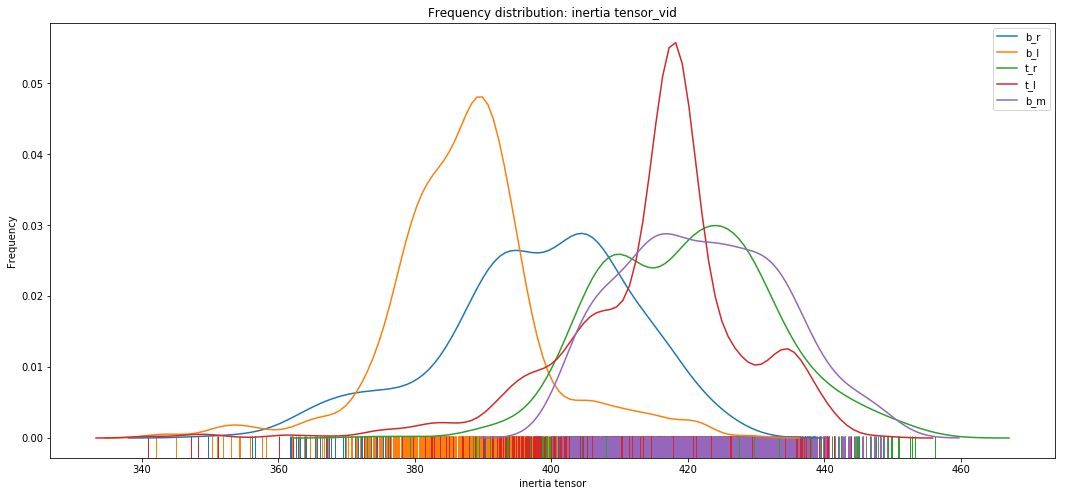

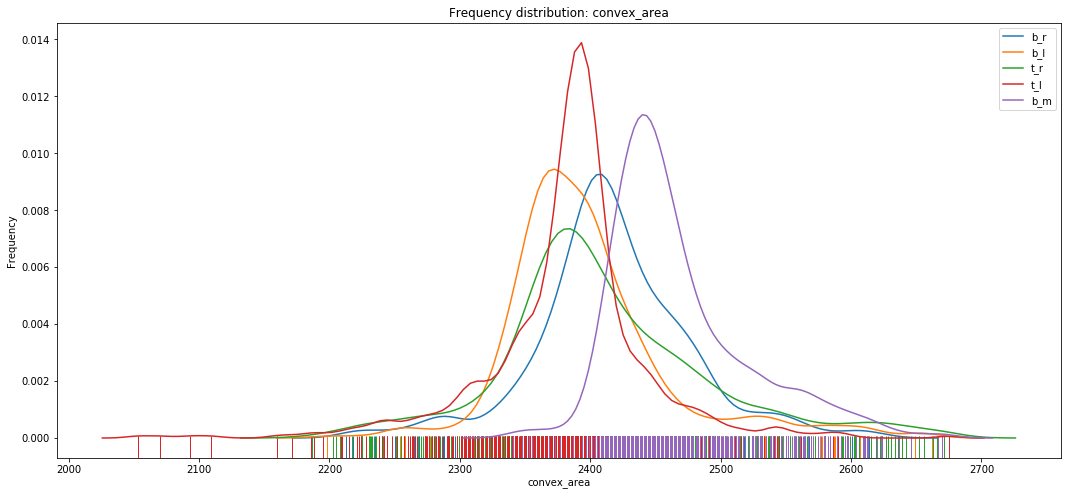

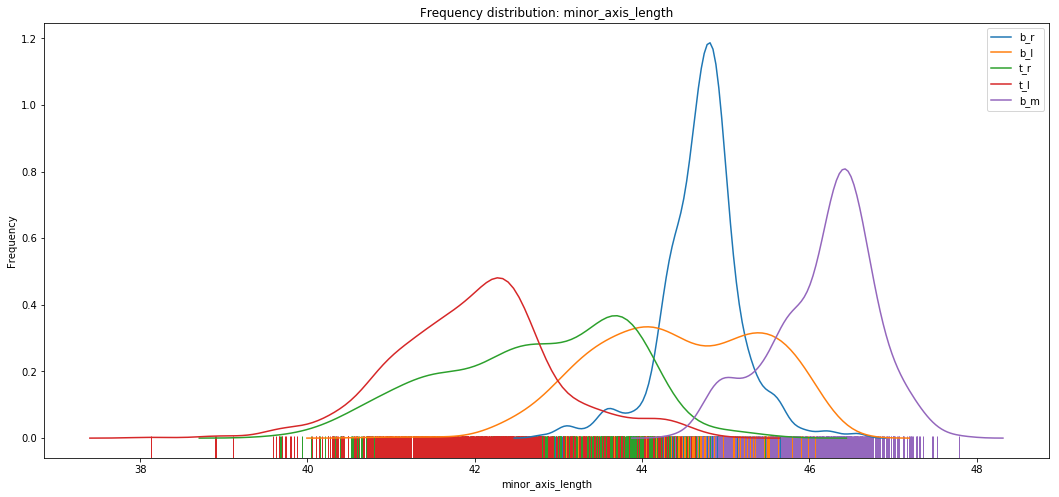

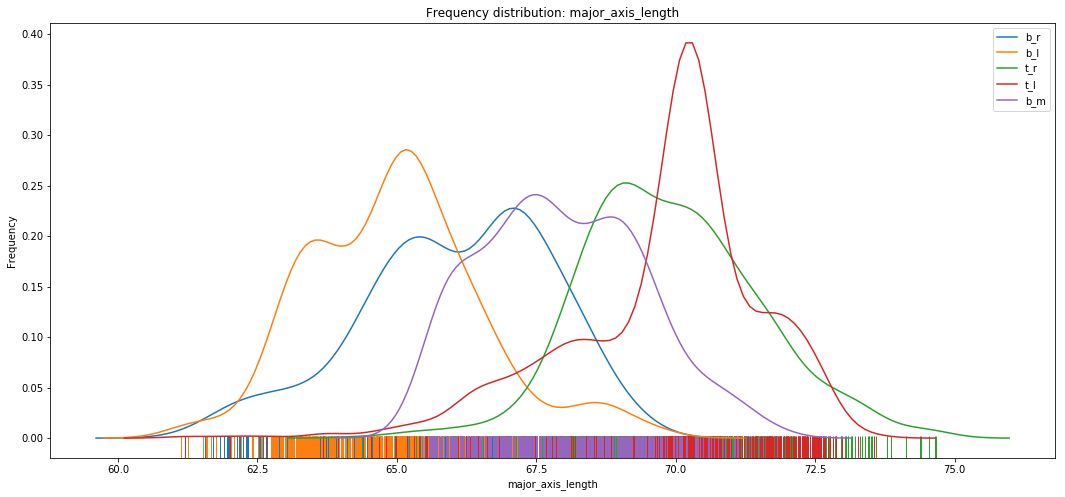

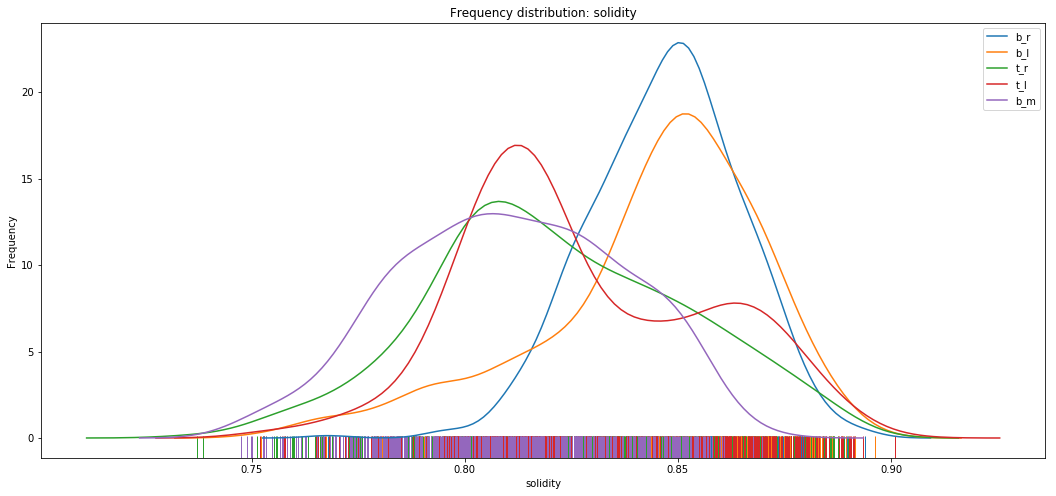

In [12]:
"""STILL RESULTS OF FILTERING"""
Inertias_list = []
for i in range(num_shape_cats):
    x = [h[0].inertia_tensor[0, 0] + h[0].inertia_tensor[1,1] for h in Filtrates_props[i]]
    Inertias_list.append(x) #list of areas for every category
print("Inertia averages: ")
[print("%s : %.f " %(framesetnames[i], np.average(Inertias_list[i]))) for i in range(num_shape_cats)]
print("Inertia variances: ")
[print("%s : %.f " %(framesetnames[i], np.var(Inertias_list[i]))) for i in range(num_shape_cats)]

fig, ax = plt.subplots(figsize=(18,8))
plt.title("Frequency distribution: inertia tensor_vid")
plt.xlabel("inertia tensor")
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = Inertias_list[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])

propnames = ["convex_area", "minor_axis_length", "major_axis_length", "solidity"]
for k in range(0, len(propnames)):
    klist = []
    for i in range(num_shape_cats):
        x = [getattr(h[0], propnames[k]) for h in Filtrates_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + propnames[k])
    plt.xlabel(propnames[k])
    plt.ylabel("Frequency")
    for j in range(0, len(framesets)-1):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])


In [13]:
"""Pt3. Separating variosu shapes
"""

'Pt3. Separating variosu shapes\n'

area averages: 
b_r : 1645 
b_l : 1645 
t_r : 1614 
t_l : 1616 
b_m : 1590 
odd_s : 1545 
broken : 1131 
area variances: 
b_r : 2759 
b_l : 4447 
t_r : 3845 
t_l : 3175 
b_m : 18023 
odd_s : 37245 
broken : 169267 
convex_area averages: 
b_r : 2128 
b_l : 2066 
t_r : 2080 
t_l : 2077 
b_m : 2148 
odd_s : 2000 
broken : 1385 
convex_area variances: 
b_r : 28769 
b_l : 19143 
t_r : 6265 
t_l : 7492 
b_m : 62607 
odd_s : 99279 
broken : 299222 
minor_axis_length averages: 
b_r : 42 
b_l : 40 
t_r : 39 
t_l : 39 
b_m : 44 
odd_s : 39 
broken : 33 
minor_axis_length variances: 
b_r : 9 
b_l : 3 
t_r : 2 
t_l : 2 
b_m : 6 
odd_s : 35 
broken : 58 
major_axis_length averages: 
b_r : 63 
b_l : 64 
t_r : 70 
t_l : 70 
b_m : 65 
odd_s : 65 
broken : 51 
major_axis_length variances: 
b_r : 17 
b_l : 23 
t_r : 5 
t_l : 10 
b_m : 55 
odd_s : 71 
broken : 217 
solidity averages: 
b_r : 1 
b_l : 1 
t_r : 1 
t_l : 1 
b_m : 1 
odd_s : 1 
broken : 1 
solidity variances: 
b_r : 0 
b_l : 0 
t_r : 0 
t_l :

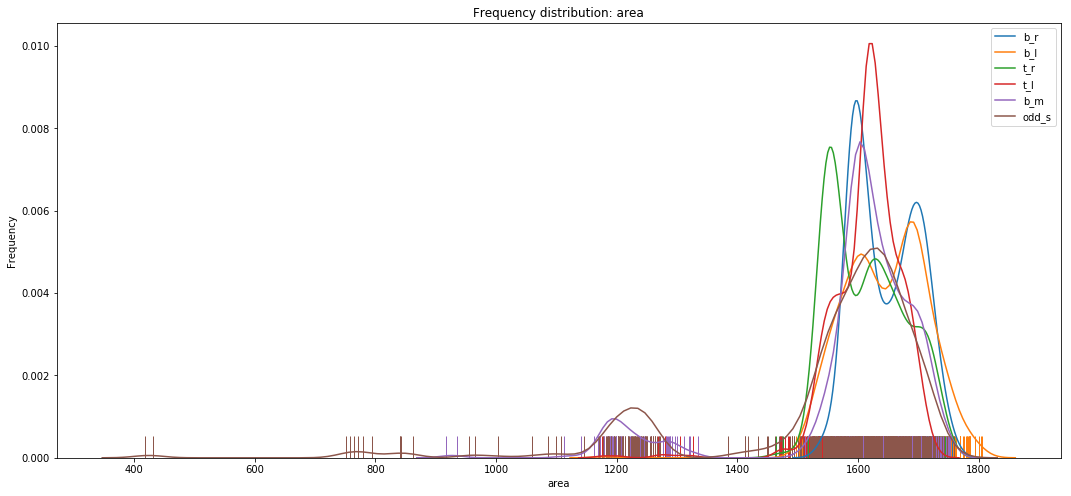

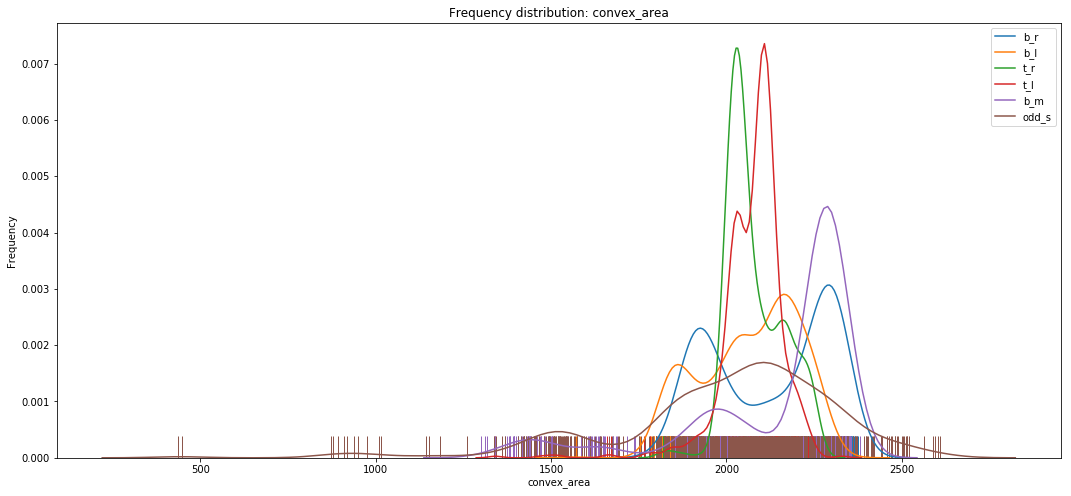

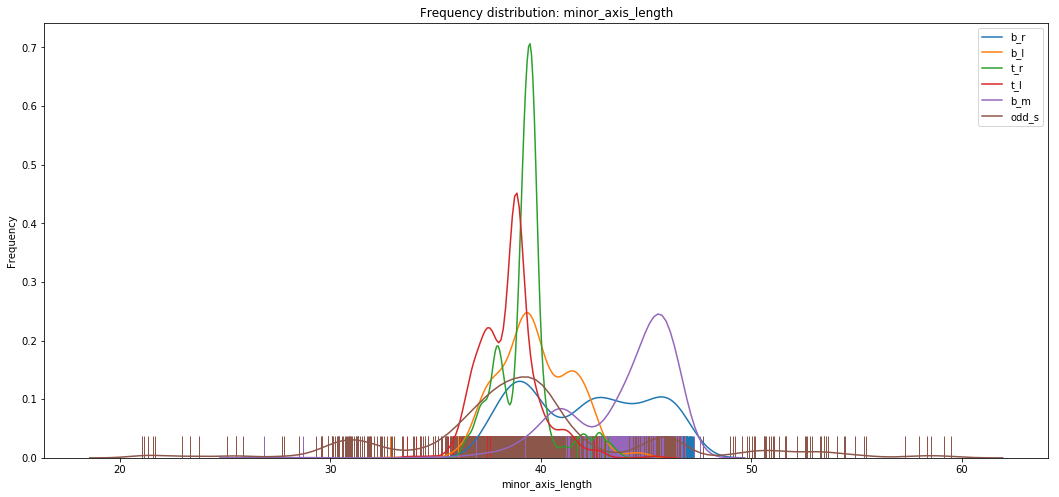

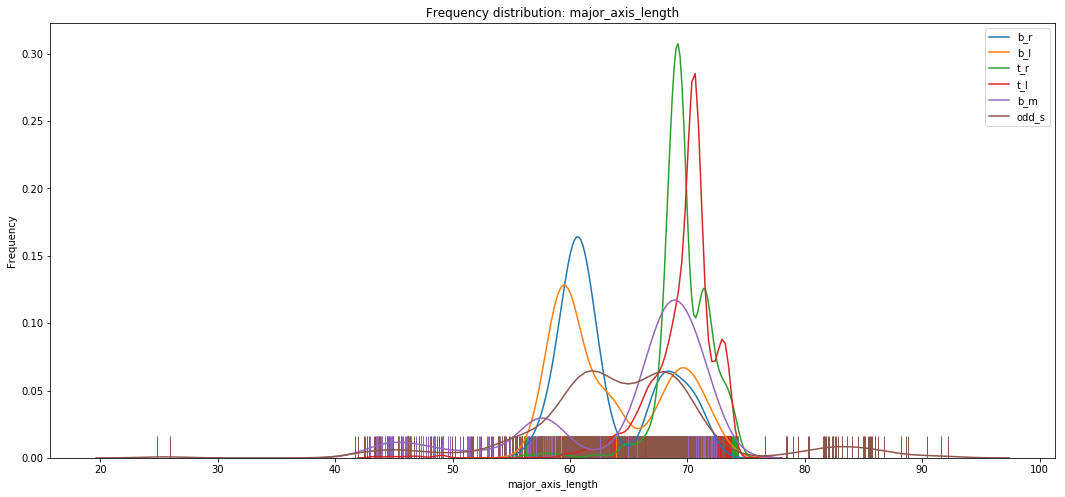

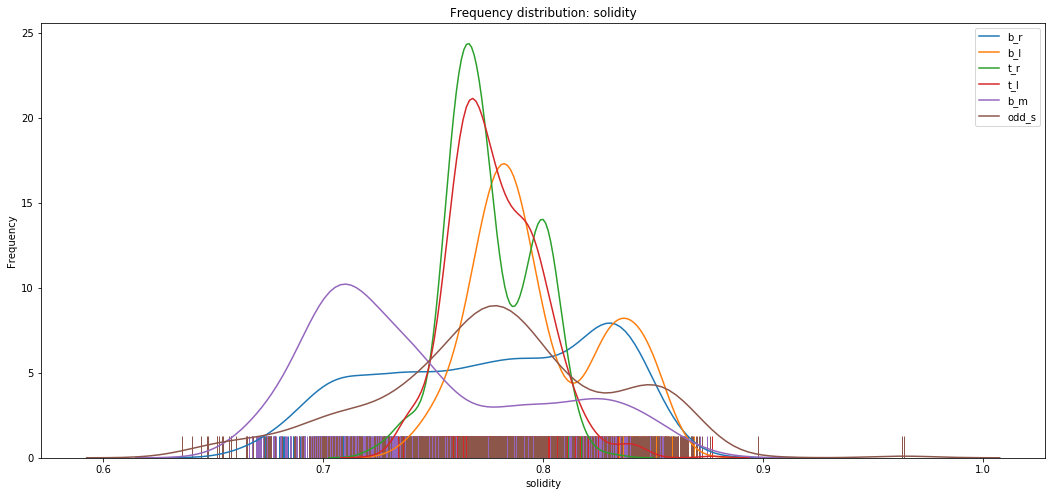

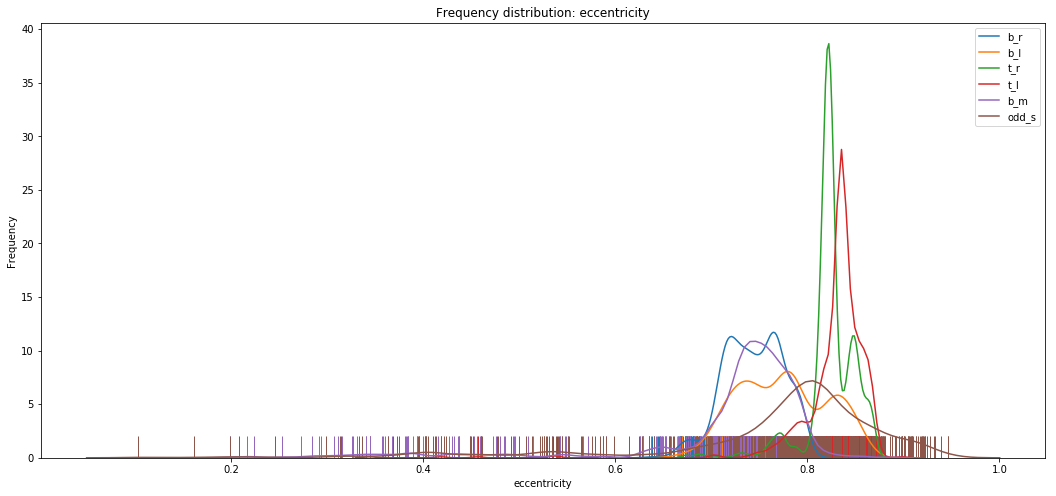

In [19]:
"SEE HOW THE ISODATA FILTER TREATS FRAMES - UNFILTERED"

                                           

Inertia averages: 
b_r : 332 
b_l : 327 
t_r : 402 
t_l : 399 
b_m : 428 
odd_s : nan 
broken : nan 
Inertia variances: 
b_r : 188 
b_l : 239 
t_r : 119 
t_l : 226 
b_m : 119 
odd_s : nan 
broken : nan 
area averages: 
b_r : 1642 
b_l : 1638 
t_r : 1611 
t_l : 1621 
b_m : 1634 
odd_s : nan 
broken : nan 
area variances: 
b_r : 2922 
b_l : 3553 
t_r : 3421 
t_l : 2015 
b_m : 2799 
odd_s : nan 
broken : nan 
extent averages: 
b_r : 1 
b_l : 1 
t_r : 1 
t_l : 1 
b_m : 1 
odd_s : nan 
broken : nan 
extent variances: 
b_r : 0 
b_l : 0 
t_r : 0 
t_l : 0 
b_m : 0 
odd_s : nan 
broken : nan 


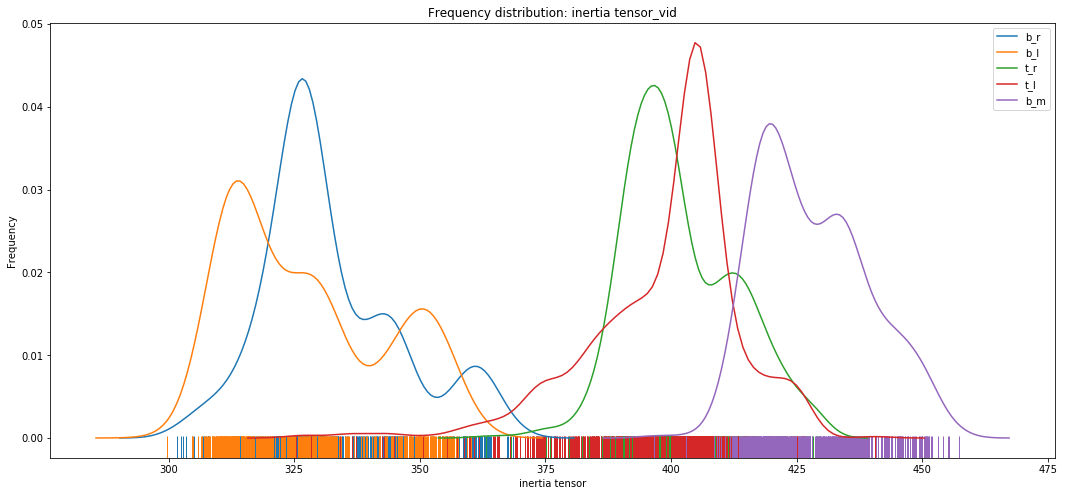

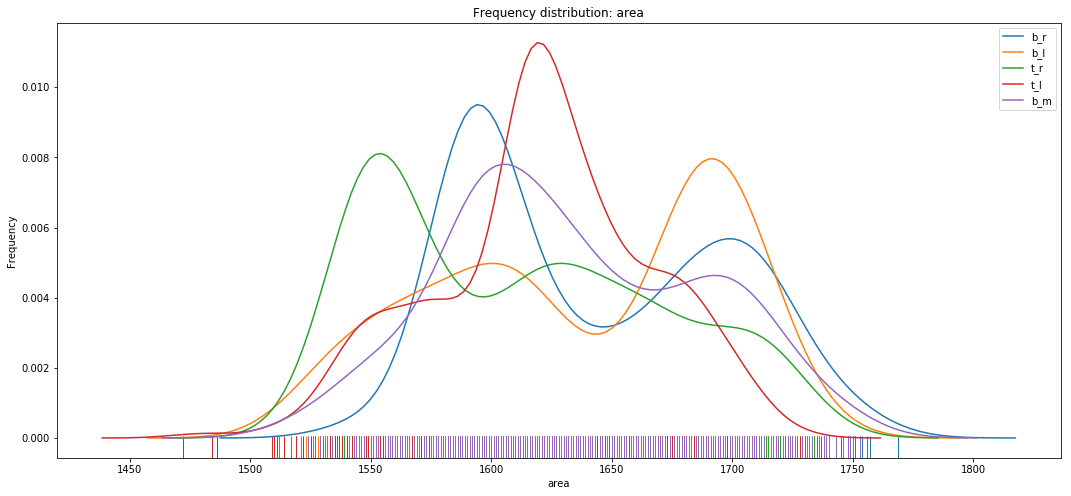

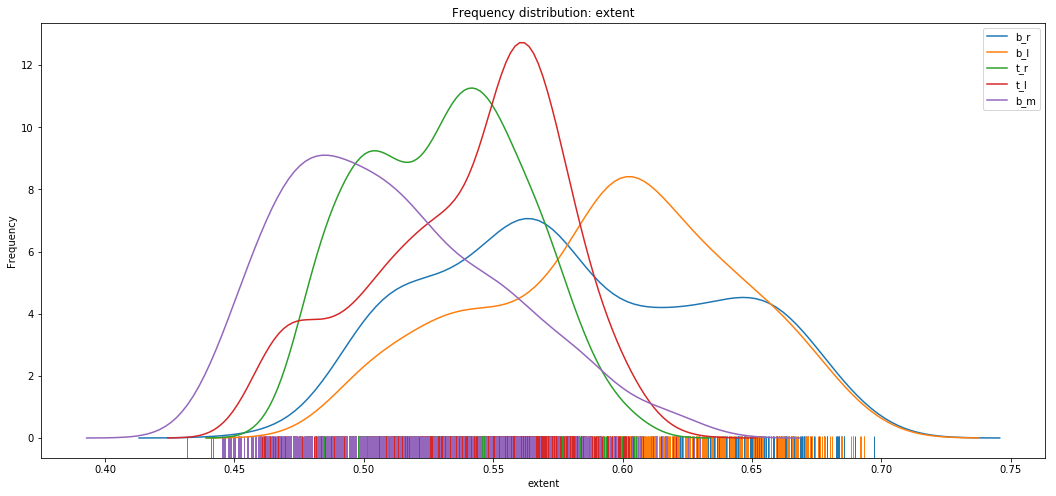

In [15]:
"""PTINTING RESULTS OF FILTERING - ISODATA THRESHOLDS"""
propnames = ["area", "extent"]
for k in range(0, len(propnames)):
    klist = []
    for i in range(num_shape_cats):
        x = [getattr(h[1], propnames[k]) for h in Filtrates_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + propnames[k])
    plt.xlabel(propnames[k])
    plt.ylabel("Frequency")
    for j in range(0, len(framesets)-1):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
        

# most oddly shaped frames have elongated shapes, and the mnor axis length is below 40, except for one (of one partcular type)
# where the pixels for a 'T' shape; this, while more rounded, has a huge convex hull. All frames wth convex hull area 
# over 2500 (very conservatve estimate) areoddly shaped (transition frames). 
# Together the criteria select for frames not in transition.
#16766 is misclassified, but it isvery like a normally shaped t_l on most measures, so maybe it should be counted as one for this program

Inertia averages: 
b_r : 363 
b_l : 353 
t_r : 400 
t_l : 396 
b_m : 389 
odd_s : 364 
broken : 248 
Inertia variances: 
b_r : 2164 
b_l : 1433 
t_r : 222 
t_l : 525 
b_m : 4071 
odd_s : 5249 
broken : 11896 
Inertia averages: 
b_r : 332 
b_l : 327 
t_r : 402 
t_l : 399 
b_m : 428 
odd_s : nan 
broken : nan 
Inertia variances: 
b_r : 188 
b_l : 239 
t_r : 119 
t_l : 226 
b_m : 119 
odd_s : nan 
broken : nan 
convex_area averages: 
b_r : 2128 
b_l : 2066 
t_r : 2080 
t_l : 2077 
b_m : 2148 
odd_s : 2000 
broken : 1385 
convex_area variances: 
b_r : 28769 
b_l : 19143 
t_r : 6265 
t_l : 7492 
b_m : 62607 
odd_s : 99279 
broken : 299222 
convex_area averages: 
b_r : 2042 
b_l : 2032 
t_r : 2079 
t_l : 2086 
b_m : 2288 
odd_s : nan 
broken : nan 
convex_area variances: 
b_r : 18927 
b_l : 19449 
t_r : 5404 
t_l : 4475 
b_m : 814 
odd_s : nan 
broken : nan 
minor_axis_length averages: 
b_r : 42 
b_l : 40 
t_r : 39 
t_l : 39 
b_m : 44 
odd_s : 39 
broken : 33 
minor_axis_length variances: 
b

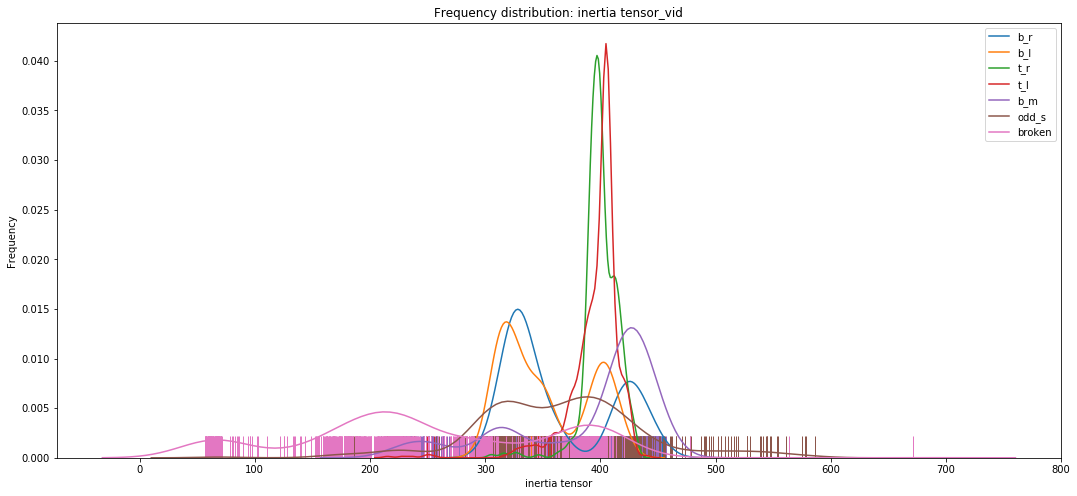

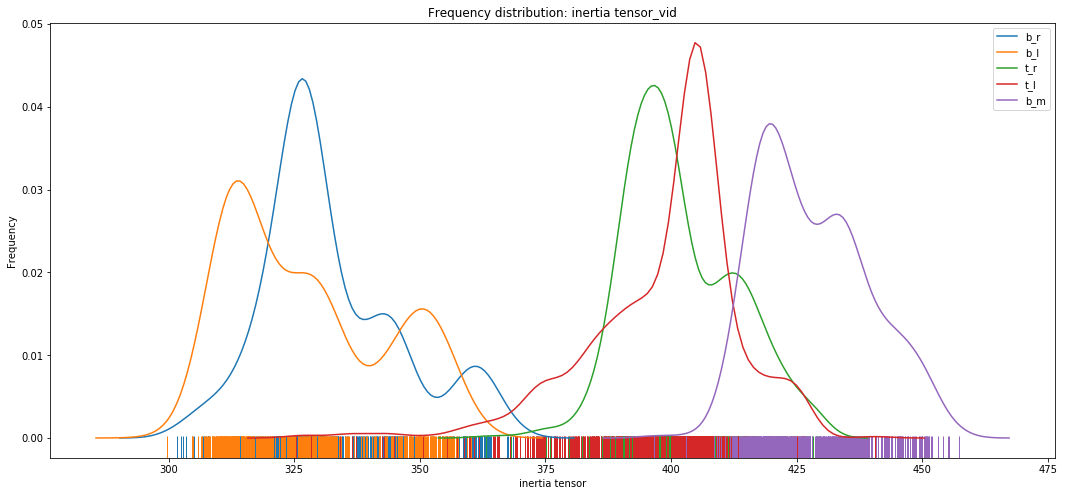

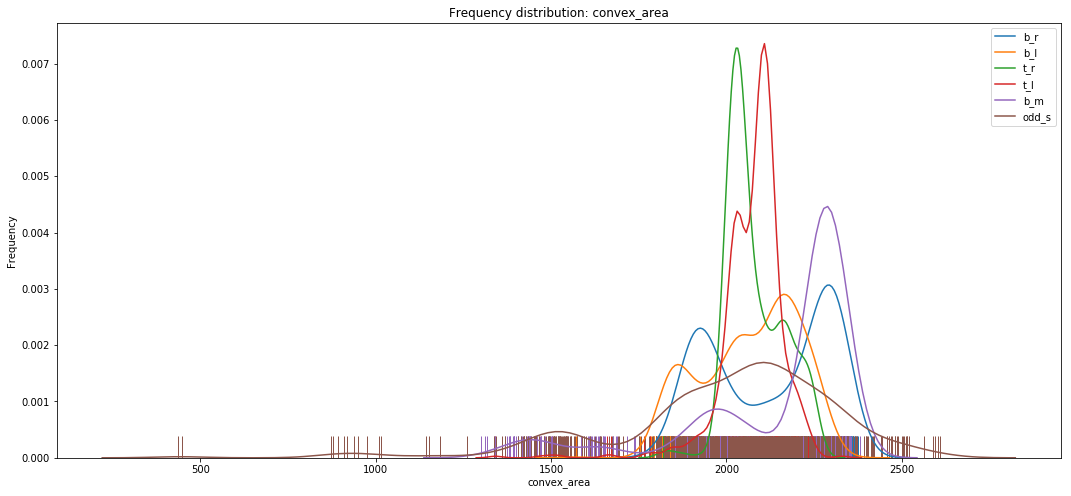

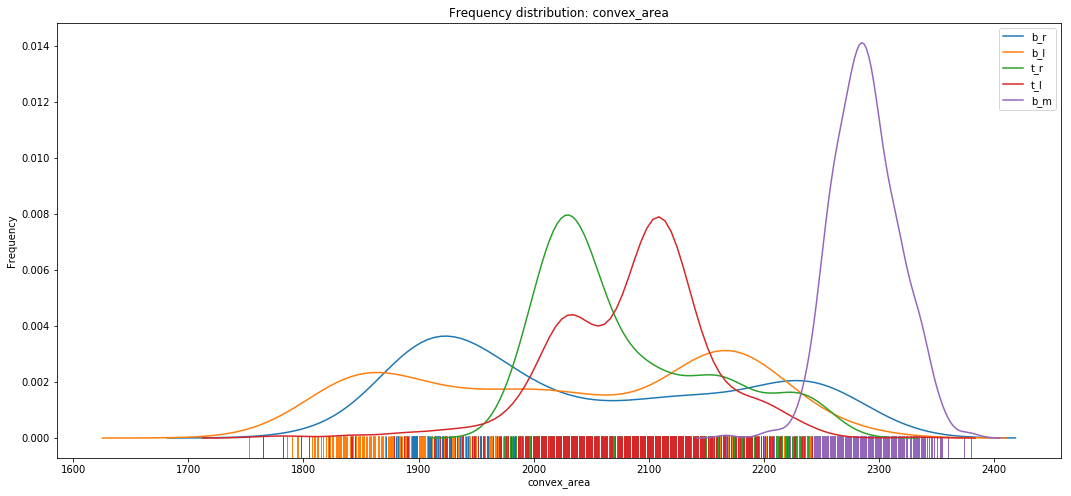

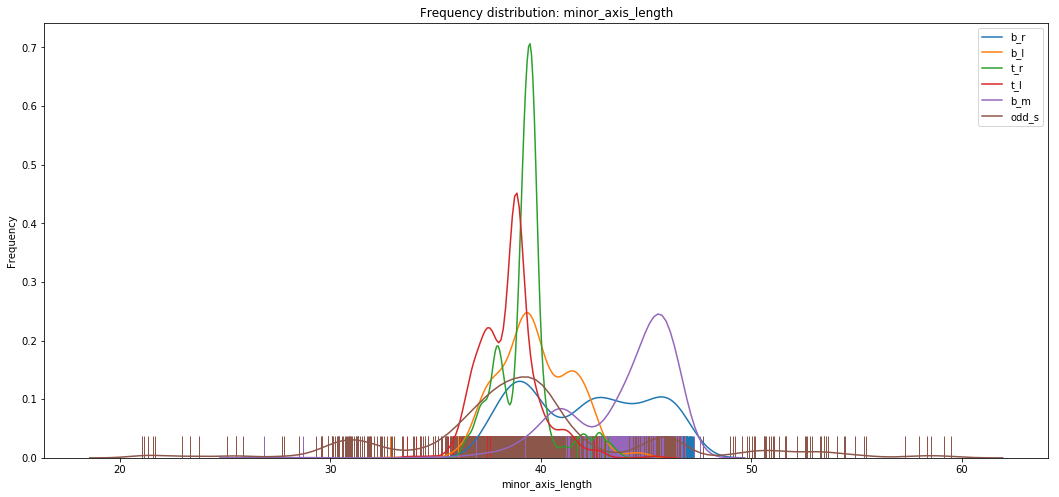

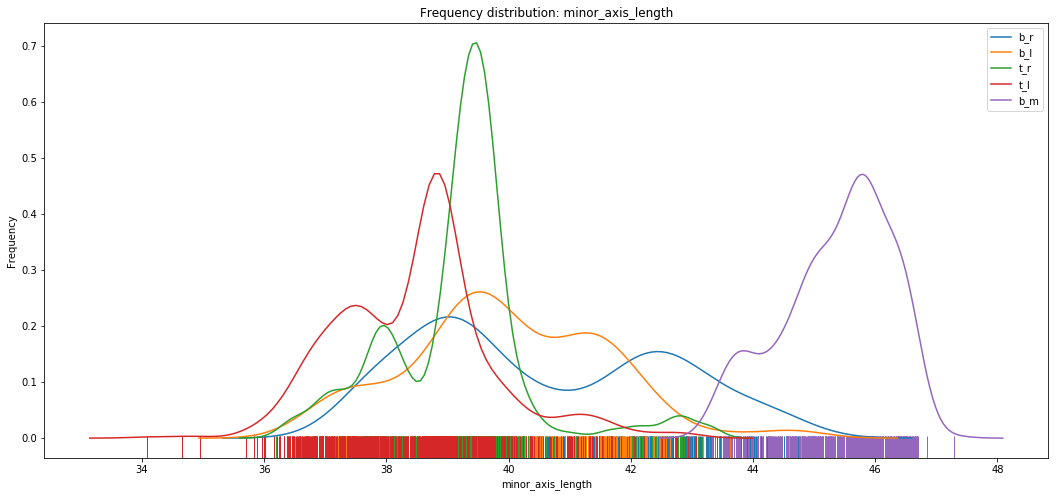

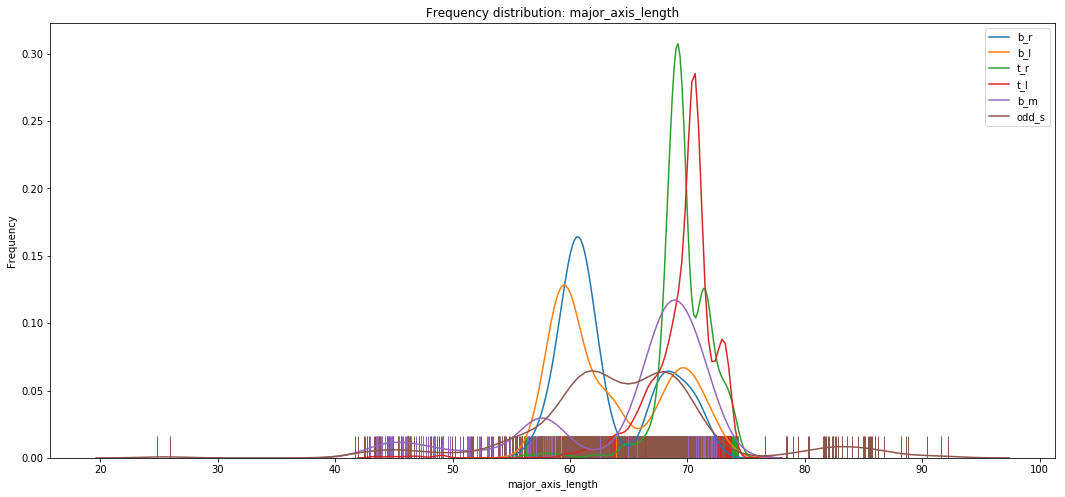

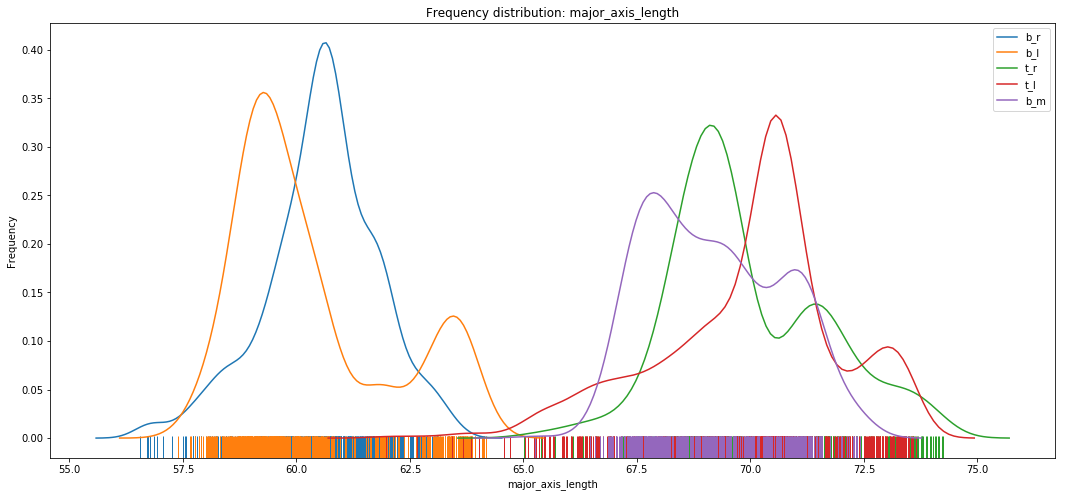

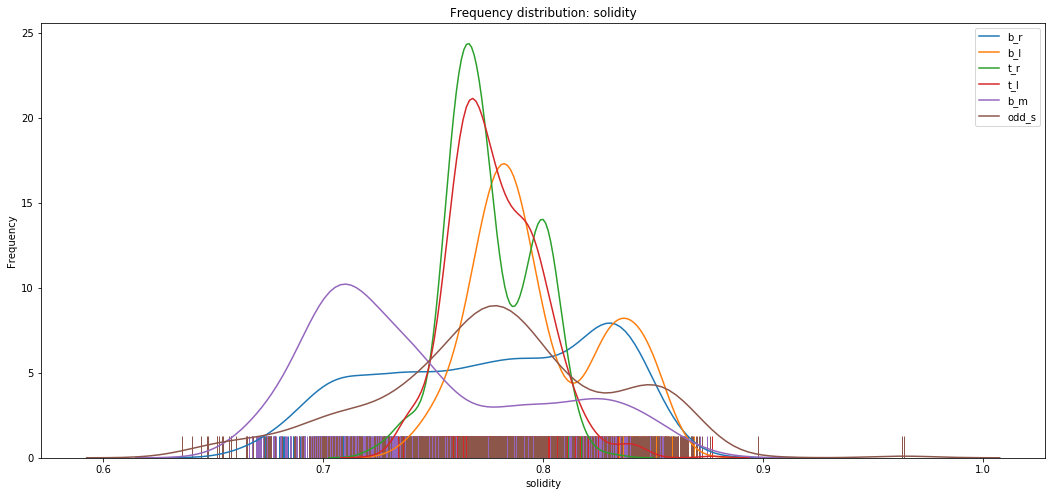

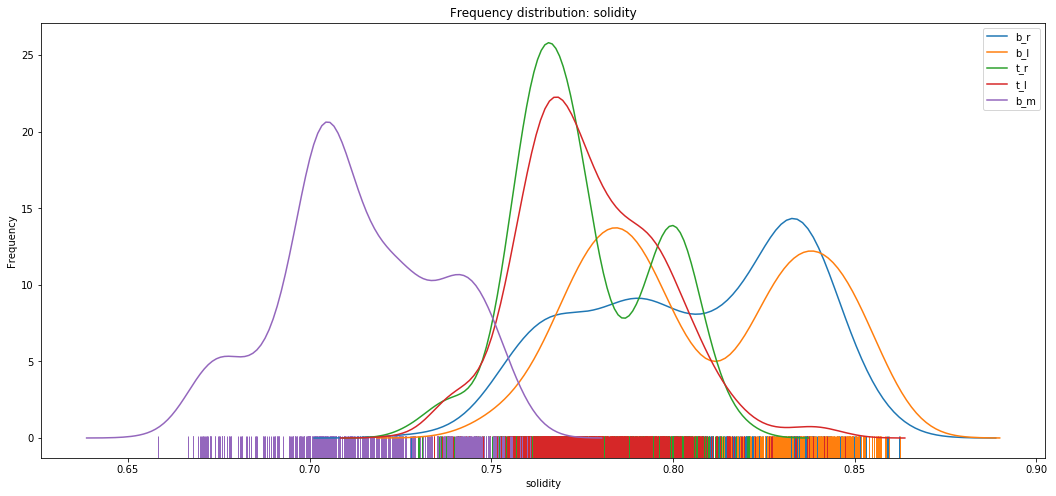

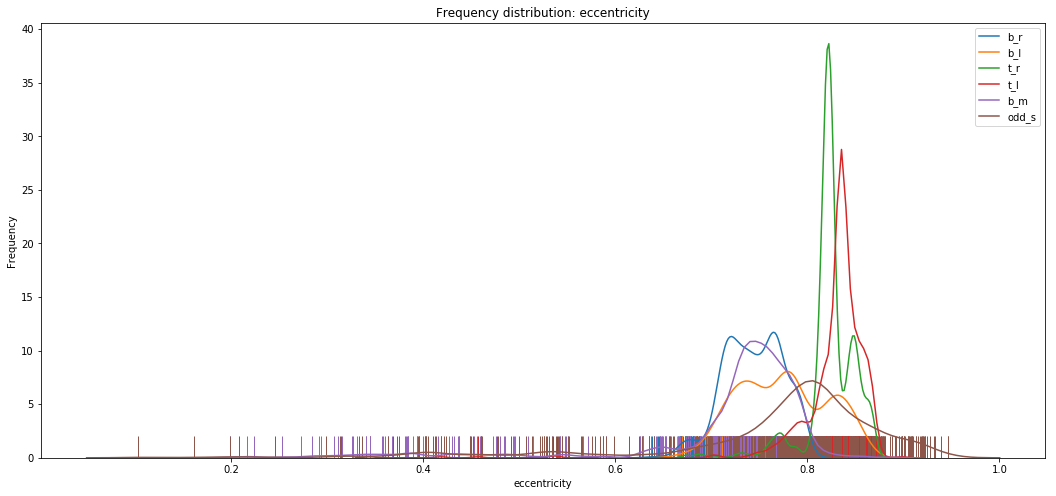

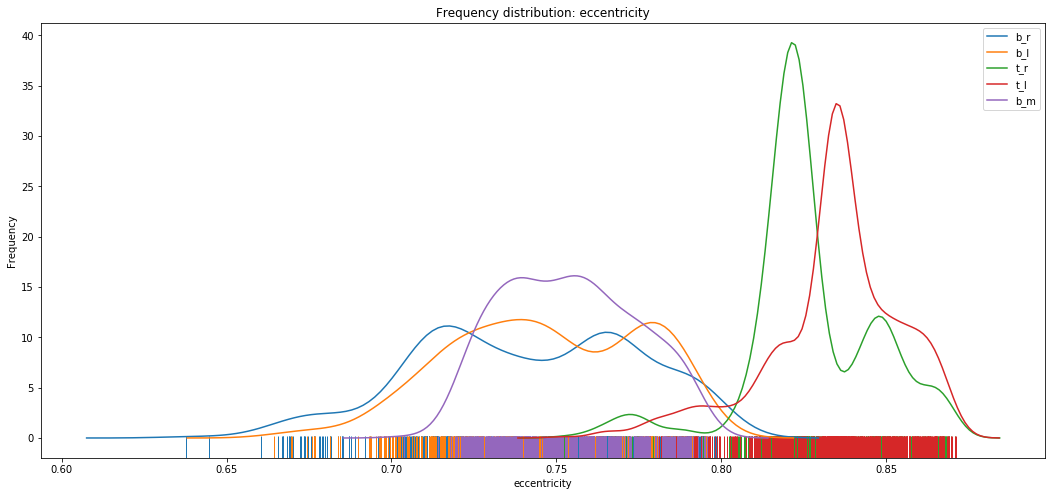

In [21]:
"""FINDING CORRECT THRESHOLDS FOR SHAPE DISCRIMINATION"""

"""STILL RESULTS OF FILTERING"""
Inertias_list = []
for i in range(num_shape_cats):
    x = [h.inertia_tensor[0, 0] + h.inertia_tensor[1,1] for h in T_thresh_props[i]]
    Inertias_list.append(x) #list of areas for every category
print("Inertia averages: ")
[print("%s : %.f " %(framesetnames[i], np.average(Inertias_list[i]))) for i in range(num_shape_cats)]
print("Inertia variances: ")
[print("%s : %.f " %(framesetnames[i], np.var(Inertias_list[i]))) for i in range(num_shape_cats)]

fig, ax = plt.subplots(figsize=(18,8))
plt.title("Frequency distribution: inertia tensor_vid")
plt.xlabel("inertia tensor")
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = Inertias_list[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])

    
Inertias_list = []
for i in range(num_shape_cats):
    x = [h[1].inertia_tensor[0, 0] + h[1].inertia_tensor[1,1] for h in Filtrates_props[i]]
    Inertias_list.append(x) #list of areas for every category
print("Inertia averages: ")
[print("%s : %.f " %(framesetnames[i], np.average(Inertias_list[i]))) for i in range(num_shape_cats)]
print("Inertia variances: ")
[print("%s : %.f " %(framesetnames[i], np.var(Inertias_list[i]))) for i in range(num_shape_cats)]

fig, ax = plt.subplots(figsize=(18,8))
plt.title("Frequency distribution: inertia tensor_vid")
plt.xlabel("inertia tensor")
plt.ylabel("Frequency")
for j in range(0, len(framesets)):
    x = Inertias_list[j]
    sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
    
    
    
    
propnames = ["convex_area", "minor_axis_length", "major_axis_length", "solidity", "eccentricity"]
for k in range(0, len(propnames)):
    klist = []
    for i in range(num_shape_cats):
        x = [getattr(h, propnames[k]) for h in T_thresh_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + propnames[k])
    plt.xlabel(propnames[k])
    plt.ylabel("Frequency")
    for j in range(0, len(framesets)-1):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
        
    klist = []
    for i in range(num_shape_cats):
        x = [getattr(h[1], propnames[k]) for h in Filtrates_props[i]]
        klist.append(x) #list of areas for every category
    print("%s averages: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.average(klist[i]))) for i in range(num_shape_cats)]
    print("%s variances: " %propnames[k])
    [print("%s : %.f " %(framesetnames[i], np.var(klist[i]))) for i in range(num_shape_cats)]    
    fig, ax = plt.subplots(figsize=(18,8))
    #plt.xticks(np.arange(0, 2501, 75))
    plt.title("Frequency distribution: " + propnames[k])
    plt.xlabel(propnames[k])
    plt.ylabel("Frequency")
    for j in range(0, len(framesets)-1):
        x = klist[j]
        sns.distplot(x, hist = False, rug=True, label = framesetnames[j])
        
        


# don't use: extent, perimeter, minor axis lengths, solidity, eccetricity
# inertia: 300 - 360 br/bl, 350 - 415 tr/tl, 417/412 - bm
# mal: 56 - 63 br/bl, 63 - 70 tr/tl, 68 bm
# ecc: .63 - .78 br/bl, .76 - .83 tr/tl, .76 bm

# if solidity <= .76 and inertia > 400 => bm
# elif inertia >=355 and mal >= 63 => tl/tr
# elif inertia <= 355 and mal <= 63 => bl/br
# else unclassifiable

In [17]:
"""DO A PCA ON EACH OF THE SETS AND PLOT SEPARATION. DISPLAY PRINCIPAL AXIS LOADINGS"""

'DO A PCA ON EACH OF THE SETS AND PLOT SEPARATION. DISPLAY PRINCIPAL AXIS LOADINGS'